The goal of using Denoising Autoencoders (DAEs) in domain adaptation is to find robust and domain-invariant features that can improve the performance of classifiers on target domain data, especially when labeled data in the target domain is scarce or not available.

**Denoising Autoencoders (DAEs)**




DAEs are designed to reconstruct clean data from noisy input. In domain adaptation, DAEs can be used to learn robust feature representations that are less sensitive to domain-specific noise and variations. By training the autoencoder to denoise the data, the model learns to focus on the underlying structure and features that are relevant across different domains.


Combining DAEs with domain adaptation can be particularly effective. For example, DAEs can be used to learn robust feature representations that are less sensitive to domain-specific noise and variations. These representations can then be used to train models that generalize better across different domains.

**Unsupervised Learning**

DAEs can learn meaningful representations from unlabeled data by reconstructing the original input from its noisy version. This allows them to capture the underlying structure of the data without needing labels.

**Benefits**


Robustness - DAEs help in learning robust representations that are less affected by domain-specific noise and variations.

Generalization - By focusing on the underlying structure of the data, DAEs can improve generalization to new domains.

**Datasets**



*   The MNIST (Modified National Institute of Standards and Technology)     
    database is a large collection of handwritten digits
*   The USPS (United States Postal Service) dataset is a collection of
    handwritten digit images that were scanned from envelopes by the U.S. Postal Service.



**Imports**

In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Data Preparation**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("stanfordu/street-view-house-numbers")

print("Path to dataset files:", path)

100%|██████████| 2.50G/2.50G [01:08<00:00, 39.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/stanfordu/street-view-house-numbers/versions/2


In [4]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(path)

There are 3 directories and 3 images in '/root/.cache/kagglehub/datasets/stanfordu/street-view-house-numbers/versions/2'.
There are 1 directories and 0 images in '/root/.cache/kagglehub/datasets/stanfordu/street-view-house-numbers/versions/2/train'.
There are 0 directories and 33403 images in '/root/.cache/kagglehub/datasets/stanfordu/street-view-house-numbers/versions/2/train/train'.
There are 1 directories and 0 images in '/root/.cache/kagglehub/datasets/stanfordu/street-view-house-numbers/versions/2/test'.
There are 0 directories and 13070 images in '/root/.cache/kagglehub/datasets/stanfordu/street-view-house-numbers/versions/2/test/test'.
There are 1 directories and 0 images in '/root/.cache/kagglehub/datasets/stanfordu/street-view-house-numbers/versions/2/extra'.
There are 0 directories and 202354 images in '/root/.cache/kagglehub/datasets/stanfordu/street-view-house-numbers/versions/2/extra/extra'.


In [6]:
svhn_path_train = os.path.join(path, 'train')
svhn_path_test = os.path.join(path, 'test')

In [7]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 32x32
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to range [-1, 1]
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.ColorJitter(contrast=0.5),
    transforms.Grayscale(num_output_channels=1),
])


# Transformation to normalize test images
simple_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 32x32
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Source dataset
# Load training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=simple_transform)
# Load the training and testing datasets
usps_train_dataset = datasets.ImageFolder(root=svhn_path_train, transform=transform)




# Create data loaders


# source domain loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# target domain loaders
usps_train_loader = DataLoader(usps_train_dataset, batch_size=32, shuffle=True)



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.40MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
len(train_loader), len(test_loader)

(1875, 313)

In [9]:

# Function to add noise to images
def add_noise(images, noise_factor=0.5):
    # Add Gaussian noise to images
    noisy_images = images + noise_factor * torch.randn_like(images)
    # Clip to ensure pixel values are in [0, 1] range
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

# Example usage with MNIST training data
# for data, _ in train_loader:
#     noisy_data = add_noise(data)  # Create noisy version of images
#     break  # For demonstration purposes, only process one batch


**Models**

AutoEncoder

DAEs consist of the same two main components as standard autoencoders:



*   Encoder: Maps the input data to a lower-dimensional latent space.
*   Decoder: Reconstructs the original data from the compressed latent  
    representation.





In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder: Gradually compress the input
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            nn.Dropout2d(p=0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
            nn.Dropout2d(p=0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 7x7 -> 3x3
            nn.Dropout2d(p=0.2)
        )

        # Latent Space: Bottleneck representation
        self.latent_space = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Maintain 3x3
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=0.2),

        )

        # Decoder: Reconstruct the input from the bottleneck
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output normalized to range [0, 1]
        )

    def forward(self, x):
        # Pass through encoder
        encoded = self.encoder(x)
        # print('encode shape',encoded.shape)
        # Pass through latent space
        latent = self.latent_space(encoded)
        # print('latent shape',latent.shape)
        # Reconstruct with decoder
        decoded = self.decoder(latent)
        # print('decoded shape',decoded.shape)
        return decoded



In [11]:
# Simple classifier
class Classifier(nn.Module):
    def __init__(self, num_inputs, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(num_inputs, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)  # Assuming 10 classes
        )

    def forward(self, x):
        return self.fc(x)

**Training the DAE**

In [12]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#train model
num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  for data, _ in train_loader:
    noisy_data = add_noise(data).to(device)
    clean_data = data.to(device)

    # print(clean_data.shape)

    # forward pass
    outputs = model(noisy_data)

    # print(outputs.shape)

    # calculate loss
    loss = criterion(outputs, clean_data)

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.0236
Epoch [2/10], Loss: 0.0178
Epoch [3/10], Loss: 0.0197
Epoch [4/10], Loss: 0.0153
Epoch [5/10], Loss: 0.0188
Epoch [6/10], Loss: 0.0167
Epoch [7/10], Loss: 0.0126
Epoch [8/10], Loss: 0.0111
Epoch [9/10], Loss: 0.0133
Epoch [10/10], Loss: 0.0153


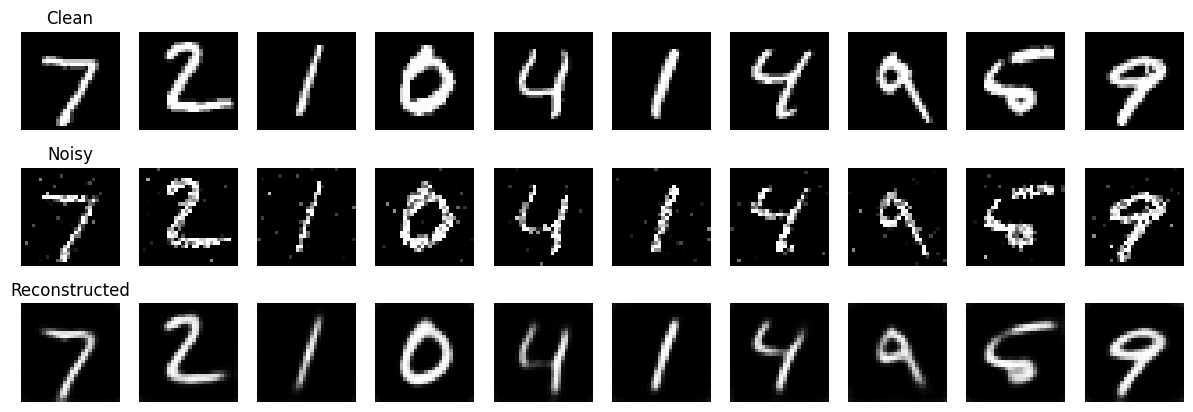

In [13]:
import matplotlib.pyplot as plt

# Visualize clean, noisy, and reconstructed images
model.eval()
with torch.no_grad():
    for clean_images, _ in test_loader:
        noisy_images = add_noise(clean_images).to(device)
        clean_images = clean_images.to(device)

        reconstructed = model(noisy_images).cpu()
        noisy_images = noisy_images.cpu()
        clean_images = clean_images.cpu()

        fig, axes = plt.subplots(3, 10, figsize=(15, 5))
        for i in range(10):
            axes[0, i].imshow(clean_images[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(noisy_images[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')
            axes[2, i].imshow(reconstructed[i].squeeze(), cmap='gray')
            axes[2, i].axis('off')
        axes[0, 0].set_title("Clean")
        axes[1, 0].set_title("Noisy")
        axes[2, 0].set_title("Reconstructed")
        plt.show()
        break


In [14]:
model.eval()
validation_loss = 0.0
with torch.no_grad():
    for data, _ in test_loader:
        noisy_data = add_noise(data).to(device)
        clean_data = data.to(device)
        outputs = model(noisy_data)
        loss = criterion(outputs, clean_data)
        validation_loss += loss.item()
print(f"Validation Loss: {validation_loss / len(test_loader):.4f}")


Validation Loss: 0.8620


**Feature Extraction**

In [15]:
source_features = []
source_labels = []

with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        inputs = inputs.view(inputs.size(0), 1, 28, 28)
        features = model.encoder(inputs)
        features = features.view(features.size(0), -1)
        source_features.append(features)
        source_labels.append(labels)

source_features = torch.cat(source_features)
source_labels = torch.cat(source_labels)


In [16]:
source_features.shape

torch.Size([60000, 1152])

**Model Training**

In [21]:
# Train the classifier on the extracted source features

input_size = source_features.shape[1]
num_classes = 10


classifier = Classifier(input_size, num_classes).to(device)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.001)
classifier_loss = nn.CrossEntropyLoss()

num_epochs = 1000
for epoch in range(num_epochs):
    outputs = classifier(source_features)
    outputs = outputs.to(device)
    source_labels = source_labels.to(device)
    loss = classifier_loss(outputs, source_labels)

    classifier_optimizer.zero_grad()
    loss.backward()
    classifier_optimizer.step()

    if (epoch+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.5619
Epoch [200/1000], Loss: 0.4223
Epoch [300/1000], Loss: 0.3544
Epoch [400/1000], Loss: 0.3143
Epoch [500/1000], Loss: 0.2874
Epoch [600/1000], Loss: 0.2679
Epoch [700/1000], Loss: 0.2525
Epoch [800/1000], Loss: 0.2417
Epoch [900/1000], Loss: 0.2299
Epoch [1000/1000], Loss: 0.2206


Test the classifier on the target domain features extracted by using the DAE

In [22]:
target_features = []
target_labels = []

with torch.no_grad():
    for data in usps_train_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        inputs = inputs.view(inputs.size(0), 1, 28, 28)  # Reshape to [batch_size, channels, height, width]
        features = model.encoder(inputs)
        features = features.view(features.size(0), -1)  # Flatten the features
        target_features.append(features)
        target_labels.append(labels)  # Convert labels to tensors and move to device

target_features = torch.cat(target_features)
target_labels = torch.cat(target_labels)


In [23]:
classifier.eval()
with torch.no_grad():
    outputs = classifier(target_features.to(device))
    _, predicted = torch.max(outputs, 1)  # Get the predicted class

# Calculate accuracy (if target labels are available)
if len(target_labels) > 0:
    accuracy = (predicted == target_labels.to(device)).float().mean()
    print(f'Accuracy on target domain: {accuracy.item():.4f}')
else:
    print("Target labels are not available. Cannot compute accuracy.")

print("Evaluation on target domain complete.")


Accuracy on target domain: 0.1473
Evaluation on target domain complete.


**Conculsion**

it's possible that denoising might not be the most effective technique for your specific instance of domain adaptation

Possible Reasons for bad Accuracy on target domain



*   **Domain shift**: The source and target domains might have significant    
    differences.

*   **Feature Quality**:Ensure the features extracted by the encoder are of  
    high quality
*   **Class Imbalance:**: Check for class imbalances in your target domain data.

